<a href="https://colab.research.google.com/github/Jinstronda/research-papers-pytorch/blob/main/Mnist_Data_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doing MNIST data set in Pytorch
I already done the MNIST data set manually (https://github.com/Jinstronda/Neural-Network-from-0)
But i wanna try it in Pytorch as a training set.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn # Necessary Stuff
import torchvision # Mnist Data Set is here apparently
import torchvision.datasets as datasets
from torchvision.transforms import v2, ToTensor
import pandas as pd




Right now the Data Sets are images and i want to convert them to Tensors and apply transform, transform is not needed in a simple data set like this but i wanna do it to learn


In [ ]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomZoomOut(),
    v2.RandomRotation(15)



])

mnist_trainset = datasets.MNIST(root='./data',
                                train=True,
                                download=True,
                                transform=ToTensor()
                               ) # Importing train and test Sets
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
mnist_trainset # Its a Data Set Object with 60 000 data points.


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

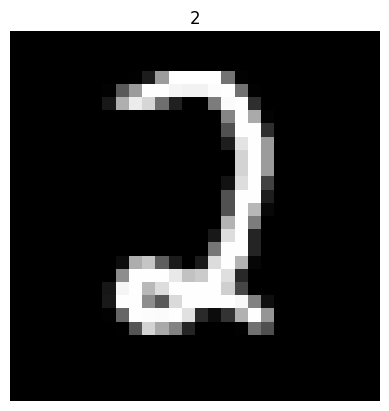

In [ ]:
labels_map = { # Shows Some Random Images from the data set to confirm its working!
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_testset), size=(1,)).item()
    img, label = mnist_testset[sample_idx]
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


# Data Loader
I wanna use Mini Batches for this data set so i need a Pytorch Data Loader


In [ ]:
from torch.utils.data import DataLoader



Im starting to understand the Data a bit better, it constains tuples of data with Labels.

In [ ]:
img,label = mnist_testset[0]
print(label)  # ok now i understand better
mnist_testset[0][0].shape
# So all the layers have 3 dimensions one of them being one because its a gray scale so i can just squeeze it i guess
mnist_testset = [(img.squeeze(0),label) for img, label in mnist_testset]
mnist_trainset = [(img.squeeze(0),label)for img,label in mnist_trainset]
train_dataloader = DataLoader(mnist_trainset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(mnist_testset, batch_size = 64, shuffle = True)

mnist_testset[0][0].shape # Testing, ok it worked

7


torch.Size([28, 28])

In [ ]:
# Gave up on doing transfomrmations as there is a lot of data alr, if i need it ill do it later

# Model Creation
Ok now the data Preloading is good and i can start developing a Neural Network

In [ ]:
class NeuralNetwork(nn.Module): # Always inherit from nn modules
  def __init__(self):
    super().__init__() # Have to start the Inheritance Class (dad?)
    self.flatten = nn.Flatten() # Apparently this flatten the images
    self.prediction = nn.Sequential(
        nn.Linear(784,64),# It comes with parameters in features (for the number of weights in the neurons) and then the number of neurons itself has
        nn.ReLU(),
        nn.Dropout(0.5),  # Adding Dropout for regularization
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,64), # Output Logits
        nn.ReLU(),
        nn.Linear(64,10)
    )

  def forward(self,x): # Inference
      x=self.flatten(x)
      predictions = self.prediction(x)
      return predictions # Debugging i forgot to do a return lmao

In [ ]:
model = NeuralNetwork() # Initializing
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4) # Apparently we dont even need to code momentum, this is way too simple lol

In [ ]:
# Some Debugging, im having some weird errors so ill try to send everything to the google graphic cardd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
for images, labels in train_dataloader:
    images = images.to(device)
    labels = labels.to(device)
for images,labels in test_dataloader:
  images = images.to(device)
  labels = labels.to(device)


In [ ]:
# Training loop
epochs = 20
epoch_count = []
train_loss_track = []
test_loss_track = []
for i in range(epochs):
  model.train() # Tem que colocar em train style
  train_loss = 0.0 # Its weird but with epochs we need to get an average of Loss for the whole epoch
  for images,labels in train_dataloader:
    images = images.to(device)
    labels = labels.to(device) # Maybe this will help with the bug
    y_pred = model(images)
    loss = loss_f(y_pred,labels)
    optimizer.zero_grad() # Resetting the Optimizer so it doesnt accumulate
    loss.backward()
    optimizer.step()
    train_loss += loss.item() # Convert to a python scalar
  train_loss /= len(train_dataloader) # Average
  model.eval()
  test_loss = 0.0
  with torch.inference_mode():
    for images,labels in test_dataloader:
      images = images.to(device)
      labels = labels.to(device)
      y_t_pred = model(images)
      t_loss = loss_f(y_t_pred,labels)
      test_loss += t_loss.item() # Need to get average as well, ishouldnt have used epochs for something so simple lmao

    test_loss /= len(test_dataloader) # Again averaging

    epoch_count.append(i) # I LOVE GRAPHS
    train_loss_track.append(train_loss) # I need to standardize my variables names or im cooked
    test_loss_track.append(test_loss) # I accidentally created a huge list loop lol, solved






  if i % 5 == 0:
    print(f"Epoch {i}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")



Epoch 0, Train Loss: 0.5863, Test Loss: 0.2511
Epoch 5, Train Loss: 0.2423, Test Loss: 0.1385
Epoch 10, Train Loss: 0.2076, Test Loss: 0.1106
Epoch 15, Train Loss: 0.1923, Test Loss: 0.1081


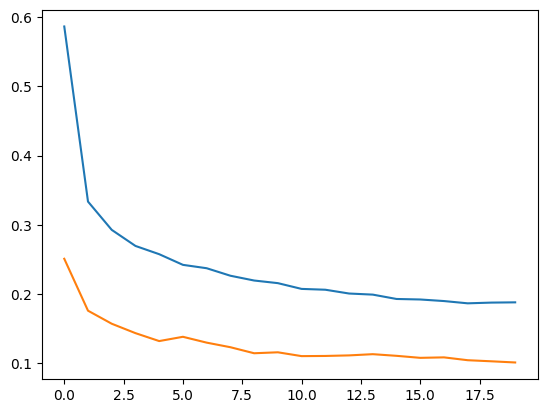

In [ ]:
plt.plot(epoch_count,train_loss_track)
plt.plot(epoch_count,test_loss_track)

plt.show()

# Reiterating
model is definetely overfitting, will add regularization
Ok model improved a lot with Regularization, still overfitting a lit tho
Maybe Learning rate is too high, let me try again
I can include some data transformation or maybe increased the regularization